In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from pathlib import Path
import sys
from matplotlib import pyplot as plt

In [2]:
PROJECT_DIR = Path("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation")
SRC_DIR = PROJECT_DIR / "src"
sys.path.append(str(SRC_DIR))

from dataset import InjectionMoldingDataset

torch.manual_seed(42)

In [3]:
dataset = InjectionMoldingDataset(0.004, 0.03, skip_processing=True).shuffle()[:1000]
test_dataset = dataset[800:]
len(test_dataset)

200

In [4]:
model_st =  torch.load("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation/experiments/find_false_negatives/models_fn_penalty/model_epoch_8.pt")
num_fns_st = []
for i, d in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    with torch.no_grad():
        y_true = d.y[:, 0].numpy()
        out_st = model_st(d)
        y_pred_st = F.softmax(out_st, dim=1).round()[:, 0].numpy()
        fn_st = confusion_matrix(y_true, y_pred_st).ravel()[2] # only false negatives
        num_fns_st.append(fn_st)

100%|██████████| 200/200 [04:33<00:00,  1.37s/it]


In [5]:
model_bl = torch.load("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation/experiments/find_false_negatives/models_baseline_2/model_epoch_8.pt")
num_fns_bl = []
for i, d in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    with torch.no_grad():
        y_true = d.y[:, 0].numpy()
        out_bl = model_bl(d)
        y_pred_bl = F.softmax(out_bl, dim=1).round()[:, 0].numpy()
        fn_bl = confusion_matrix(y_true, y_pred_bl).ravel()[2] # only false negatives
        num_fns_bl.append(fn_bl)

100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


In [6]:
pd.DataFrame(
    data=zip(num_fns_bl, num_fns_st),
    columns=["num_fns_baseline", "num_fns_strafterm"]
).describe()

,num_fns_baseline,num_fns_strafterm
count,200.000000,200.000000
mean,84.360000,84.360000
std,32.141496,32.141496
min,25.000000,25.000000
25%,63.750000,63.750000
50%,81.000000,81.000000
75%,99.250000,99.250000
max,274.000000,274.000000


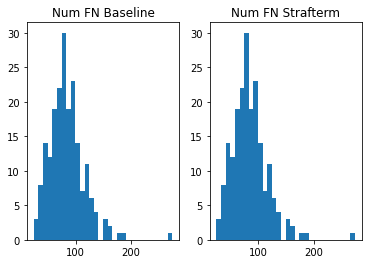

In [7]:
# Compare Histograms
fig, axes = plt.subplots(1, 2)
ax_left, ax_right = axes
num_bins = 30

ax_left.hist(num_fns_bl, bins=num_bins)
ax_left.set_title("Num FN Baseline")

ax_right.hist(num_fns_st, bins=num_bins)
ax_right.set_title("Num FN Strafterm")

plt.show()